In [110]:
include("two-level-motion.jl")
using BenchmarkTools
using PyPlot
using OrdinaryDiffEq

[ Info: Precompiling Ipopt [b6b21f68-93f8-5de0-b562-5493be1d77c9] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling OptimMOIExt [e044c2ac-1594-5fb4-97e0-e617dbc85f6c] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572] (cache misses: wrong dep version loaded (2))


In [174]:
data = TwoLevelMotionData(2π * 700e3, 0.066 * 2, 30)

(::TwoLevelMotionData{Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, Matrix{ComplexF64}}}) (generic function with 2 methods)

In [178]:
resize!(data.pulses, 0)
Ω = 2π * 10e6
tπ = π / Ω

ϕ_b2 = 1.8234765819369754
push!(data.pulses, PulseParam(Ω, 0, ϕ_b2, tπ))
push!(data.pulses, PulseParam(Ω, 0, 3 * ϕ_b2, 2 * tπ))
push!(data.pulses, PulseParam(Ω, 0, ϕ_b2, tπ))
push!(data.pulses, PulseParam(Ω, 0, 0, tπ))

4-element Vector{PulseParam}:
 PulseParam(6.2831853071795866e7, 0.0, 1.8234765819369754, 5.0e-8)
 PulseParam(6.2831853071795866e7, 0.0, 5.470429745810926, 1.0e-7)
 PulseParam(6.2831853071795866e7, 0.0, 1.8234765819369754, 5.0e-8)
 PulseParam(6.2831853071795866e7, 0.0, 0.0, 5.0e-8)

In [179]:
ts1, ψs1 = run_pulses(data, init_n(data, 0), alg=Vern7());
ts2, ψs2 = run_pulses(data, init_n(data, 5), alg=Vern7());
ts3, ψs3 = run_pulses(data, init_n(data, 10), alg=Vern7());
ts4, ψs4 = run_pulses(data, init_n(data, 15), alg=Vern7());

In [36]:
@btime run_pulses(data, $(init_n(data, 0)), 2);
@btime run_pulses(data, $(init_n(data, 0)), 2, alg=Vern7());
@btime run_pulses(data, $(init_n(data, 0)), 2, alg=Vern9());

  721.290 ms (30854 allocations: 1.43 MiB)
  371.152 ms (16557 allocations: 806.88 KiB)
  880.635 ms (38803 allocations: 1.81 MiB)


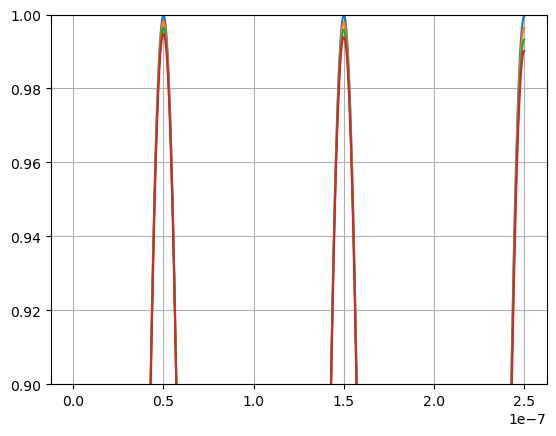

In [180]:
plot(ts1, real.(expect.(1, Ref(sigmaz(SpinBasis(1//2))), ψs1)))
plot(ts2, real.(expect.(1, Ref(sigmaz(SpinBasis(1//2))), ψs2)))
plot(ts3, real.(expect.(1, Ref(sigmaz(SpinBasis(1//2))), ψs3)))
plot(ts4, real.(expect.(1, Ref(sigmaz(SpinBasis(1//2))), ψs4)))
ylim([0.90, 1])
grid()

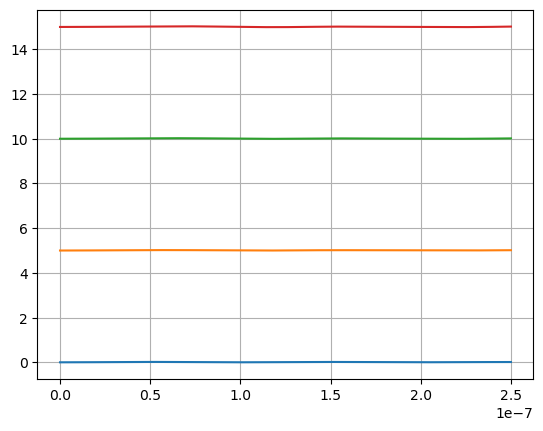

In [181]:
m_basis = data.op.basis_l.bases[2]
plot(ts1, real.(expect.(2, Ref(number(m_basis)), ψs1)))
plot(ts2, real.(expect.(2, Ref(number(m_basis)), ψs2)))
plot(ts3, real.(expect.(2, Ref(number(m_basis)), ψs3)))
plot(ts4, real.(expect.(2, Ref(number(m_basis)), ψs4)))
grid()

In [127]:
using JuMP
using FiniteDiff
using StaticArrays

In [113]:
const opt_data = TwoLevelMotionData(2π * 700e3, 0.066 * 2, 30)

(::TwoLevelMotionData{Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}}}, Matrix{ComplexF64}}}) (generic function with 2 methods)

In [172]:
resize!(opt_data.pulses, 0)
const opt_Ω = 2π * 2e6
push!(opt_data.pulses, PulseParam(opt_Ω, 0, 0, π / opt_Ω))
push!(opt_data.pulses, PulseParam(opt_Ω, 0, 0, 0))
push!(opt_data.pulses, PulseParam(opt_Ω, 0, 0, 0))
push!(opt_data.pulses, PulseParam(opt_Ω, 0, 0, 0))
push!(opt_data.pulses, PulseParam(opt_Ω, 0, 0, 0))

const opt_ψs0 = [init_n(opt_data, n) for n in 0:2]

function objective_function(t1, t2, t3, t4, t5, φ1, φ2, φ3, φ4, φ5)
    ts = t1, t2, t3, t4, t5
    φs = φ1, φ2, φ3, φ4, φ5
    for i in 1:5
        opt_data.pulses[i] = PulseParam(opt_Ω, 0, φs[i], ts[i])
    end
    σz = sigmaz(SpinBasis(1//2))
    res = 0.0
    for n in 0:2
        _, ψs = run_pulses(opt_data, opt_ψs0[n + 1], 2, alg=Vern7())
        if length(ψs) == 0
            err = 2.0
        else
            err = 1 - real(expect(1, σz, ψs[end]))
        end
        res += exp(-n / 2) * err
    end
    return res
end

function gradiant_function(g, t1, t2, t3, t4, t5, φ1, φ2, φ3, φ4, φ5)
    FiniteDiff.finite_difference_gradient!(g, x->objective_function(x...),
        @MVector[t1, t2, t3, t4, t5, φ1, φ2, φ3, φ4, φ5], Val(:forward))
    return
end

function run_opt(model)
    @variable(model, 0 .<= ts[1:5] .<= 8π / opt_Ω)
    set_start_value(ts[1], π / opt_Ω)
    @variable(model, 0 .<= φs[1:5] .<= 2π)
    # @operator(model, f, 10, objective_function)
    # @objective(model, Min, f(ts..., φs...))
    register(model, :f, 10, objective_function, gradiant_function, autodiff=false)
    @NLobjective(model, Min, f(ts..., φs...))
    JuMP.optimize!(model)
    tsv = value.(ts)
    φsv = value.(φs)
    objv = objective_function(tsv..., φsv...)
    return tsv, φsv, objv
end

run_opt (generic function with 30 methods)

In [173]:
run_opt(Model(Ipopt.Optimizer))

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7901198e-01 0.00e+00 5.73e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

LoadError: InterruptException: